# Convolutional Neural Networks - CIFAR10 dataset

In the previous notebook we have illustrated the high potential of **Convolutional Neural Networks** for image classification. In this notebook, we are going to use **CNN** to classify images of the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Unlike **MNIST**, where the images corresponded to handwritten black and white numbers, **CIFAR10** compiles a large collection of colored images of many different types. In total, there are 60000 images contained in **10 classes**, and each image has a dimension of 32x32 pixels x 3 color channels, so they are tiny images.

First of all, we are going to load the dataset, available in ***tensorflow.python.keras.datasets*** library, and preprocess these data, making them understandable to the neural network. Note that the data partition between training data and test data is already done by default:

In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.utils  import to_categorical
from tensorflow.python.keras.datasets import cifar10
  
  
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

  # Each image is 32x32x3 (3 color channels)
  
he, wi, chan = X_train[0].shape  # height, width and channels

We are going to implement a method that allows us to **randomly** visualize some images of the **CIFAR10** dataset:

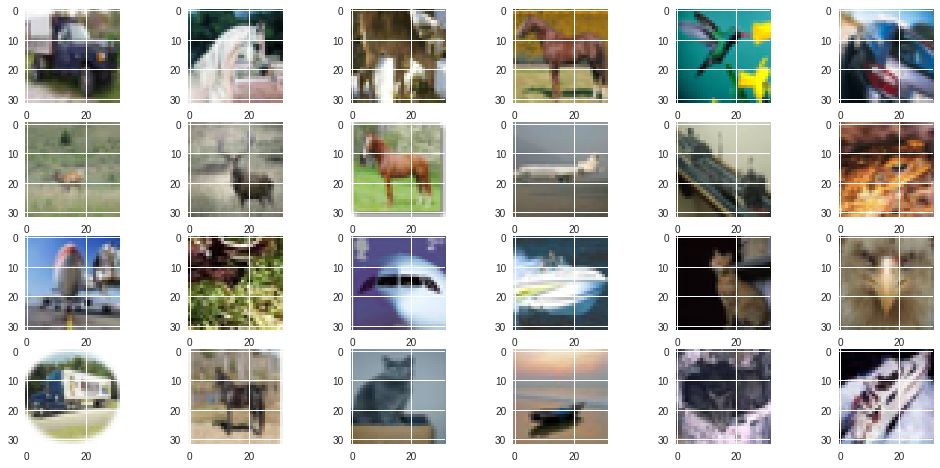

In [2]:
from random import randint

def show_imgs(X):
  
  plt.figure(figsize=(17,8))

  for i in range(0,4):  # rows
      for j in range(0,6):  # columns
          plt.subplot2grid((4,6),(i,j))  # grid: 4 rows x 6 columns
          plt.imshow(Image.fromarray(X[randint(0, X_train.shape[0])]))  # plot k-th image of X

  plt.show()

show_imgs(X_train)

As expected, a resolution of 32x32 can vaguely represent an object. However, as we will see later, classifiers based on **CNN** are even able to classify this type of tiny images.

We convert labels to categorical format and we normalize the data:

In [0]:
Y_train = to_categorical(Y_train, 10)  # Categorical labels for 100 classes
Y_test = to_categorical(Y_test, 10)

X_train = X_train.astype('float32') / 255  # Normalization
X_test = X_test.astype('float32') / 255

And then, we design and train our model based on **CNN**. In spite of being tiny images, the training is heavier than the previously seen trainings, so early termination has been used, in such a way that we can save a model that does not continue to become worse in the following *10* epochs from its *validation accuracy* last improvement. Thus, the following architecture has been empirically selected, achieving better results than the other tested architectures:

In [4]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.optimizers import SGD

CNN = Sequential()

CNN.add(Conv2D(kernel_size=4, strides=1, filters=64, padding='same', activation='relu', input_shape=(he, wi, chan)))
CNN.add(Conv2D(kernel_size=4, strides=1, filters=64, padding='same', activation='relu'))
CNN.add(MaxPooling2D(pool_size=3, strides=1))
CNN.add(BatchNormalization())

CNN.add(Conv2D(kernel_size=3, strides=1, filters=160, padding='same', activation='relu'))
CNN.add(Conv2D(kernel_size=3, strides=2, filters=160, padding='same', activation='relu'))
CNN.add(MaxPooling2D(pool_size=3, strides=1))

CNN.add(Flatten())
CNN.add(BatchNormalization())
CNN.add(Dense(256, activation='relu'))
CNN.add(Dense(10, activation='softmax'))  # 10 classes

  # decay: batch update, it decays the lr every batch. momentum: how much the previous gradients will affect the current one
  # nesterov = True: prevents the optimizer from missing the minima if the momentum is too high
sgd = SGD(lr=0.015, decay=1e-6, momentum=0.9, nesterov=True)

CNN.compile(optimizer=sgd,  # SGD: experimentally better than Adam in this case
            loss='categorical_crossentropy',
            metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='./weights-C10sgd.h5', monitor='val_acc', save_best_only='True', save_weights_only='True', verbose=1)

cbks = [EarlyStopping(monitor='val_acc', patience=10, verbose=1),  # stop training if val_acc doesnt improve past 10 epochs
       checkpoint]

CNN_hist = CNN.fit(X_train,
          Y_train,
          batch_size=100,
          epochs=80,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=cbks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/80
49900/50000 [============================>.] - ETA: 0s - loss: 1.8017 - acc: 0.4445
Epoch 00001: val_acc improved from -inf to 0.39060, saving model to ./weights-C10sgd.h5
50000/50000 [==============================] - 63s 1ms/step - loss: 1.8006 - acc: 0.4448 - val_loss: 1.9632 - val_acc: 0.3906
Epoch 2/80
49900/50000 [============================>.] - ETA: 0s - loss: 1.1322 - acc: 0.6145
Epoch 00002: val_acc improved from 0.39060 to 0.59610, saving model to ./weights-C10sgd.h5
50000/50000 [==============================] - 60s 1ms/step - loss: 1.1324 - acc: 0.6144 - val_loss: 1.3287 - val_acc: 0.5961
Epoch 3/80
49900/50000 [============================>.] - ETA: 0s - loss: 0.8872 - acc: 0.7019
Epoch 00003: val_acc did not improve from 0.59610
50000/50000 [==============================] - 60s 1ms/step - loss: 0.8870 - acc: 0.7020 - val_loss: 1.4139 - val_acc: 0.5946
Epoch 4/80
49900/50000 [============================>.] - 

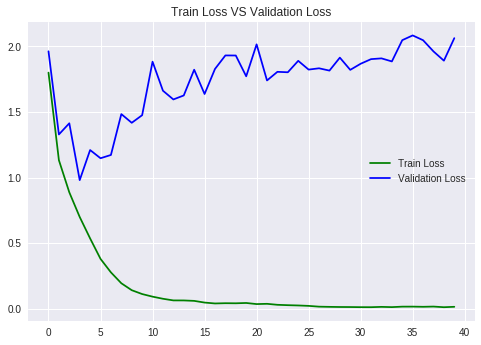

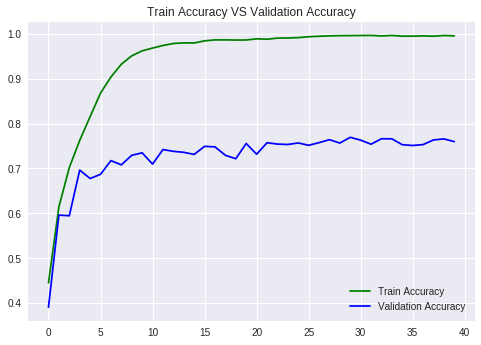

In [8]:
plt.title("Train Loss VS Validation Loss")
plt.plot(CNN_hist.history['loss'],     c='g')
plt.plot(CNN_hist.history['val_loss'], c='b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

plt.title("Train Accuracy VS Validation Accuracy")
plt.plot(CNN_hist.history['acc'],     c='g')
plt.plot(CNN_hist.history['val_acc'], c='b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()

We have compared the results between using **Adam** and using **Stochastic Gradient Descent (SGD)** as the optimization algorithm, and SGD achieves convergence to higher accuracy, in addition to providing better-shaped loss plots with no fluctuations.

We recover those weights with which the highest accuracy was achieved during the training:



In [0]:
CNN.load_weights('./weights-C10sgd.h5')

And then, we can visualize some metrics about this model, such as its **confusion matrix**:

Accuracy: 76.95 %


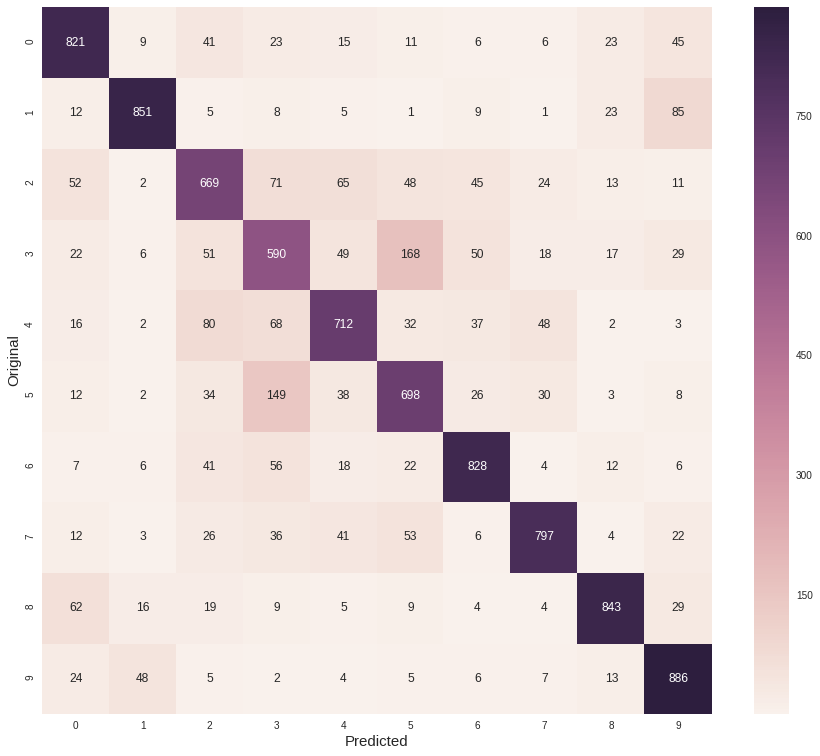

In [11]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

score = CNN.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: {:5.2f} %" .format(score[1] * 100))

Y_pred = CNN.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)  # Decode one-hot labels
Y_orig = np.argmax(Y_test, axis=1)

matConf = confusion_matrix(Y_orig, Y_pred)

falsePositive = round(((matConf[0][1])/float(Y_test.shape[0]))*100, 5)
falseNegative = round(((matConf[1][0])/float(Y_test.shape[0]))*100, 5)

plt.figure(figsize=(15,13))
ax = sb.heatmap(matConf, annot=True, fmt=".0f")  # Plot the confusion matrix
ax.set_ylabel('Original', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
plt.show()

We can train the model better by perhaps adding a few more layers, but we would need more powerful hardware and more time for that. In addition, more complex networks do not always give better results, and by looking at the **confusion matrix** we can extract that the model's performance is acceptable in the classification of **MNIST** dataset numbers, hitting nearly **77%** in **validation accuracy**.